In [1]:
#pip install reportlab
import json
import glob
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import itertools
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

2023-05-06 09:51:39.827615: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
loc='/Users/wentingjiang/Downloads/assignment2/'

In [3]:
with open(loc+'dataset.json', 'r') as file:
    data = json.load(file)

print(data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [4]:
# look at json
# multiple labels per restaurant
for i in range(20):
    print(i)
    labels = [d['label'] for d in data[i]['cuisines']]
    print(labels)

0
['Greek']
1
['Modern French']
2
['Seafood']
3
['Modern French']
4
['Seafood', 'Classic Cuisine']
5
['Seafood']
6
['Organic', 'Market Cuisine']
7
['Japanese']
8
['Belgian', 'Classic Cuisine']
9
['Classic Cuisine', 'Belgian']
10
['Classic French']
11
['Belgian', 'Classic Cuisine']
12
['Classic Cuisine']
13
['Modern French', 'Creative']
14
['Traditional Cuisine', 'Belgian']
15
['Creative']
16
['Italian']
17
['Belgian']
18
['Seasonal Cuisine', 'Belgian']
19
['Seasonal Cuisine']


In [5]:
# extract image IDs of one restaurant
one_restaurant_info=data[0]['more_details']['full_images']
one_restaurant_images=[i['image_id'] for i in one_restaurant_info]
one_restaurant_images

['2088757', '2182000', '4151606', '4151588', '2224983']

In [6]:
# do this for all restaurants
import random
res_image_dic={}
cuisine_dic={}
for res in data:
    # use cuisine type as restaurant 
    res_id= res['identifier']
    one_restaurant_info=res['more_details']['full_images']
    one_restaurant_images=[i['image_id'] for i in one_restaurant_info]
    if len(one_restaurant_images)!=0:
    # select 1 images per restaurant, otherwise too many images
        selected= one_restaurant_images[-1]#random.choices(one_restaurant_images,k=1)
    res_image_dic[res_id]=selected
    cuisine_dic[res_id] = [d['label'] for d in res['cuisines']]

In [7]:
len(cuisine_dic)

16455

In [8]:
# get all cuisine names
flat_list = [item for sublist in cuisine_dic.values() for item in sublist]
flat_list

['Greek',
 'Modern French',
 'Seafood',
 'Modern French',
 'Seafood',
 'Classic Cuisine',
 'Seafood',
 'Organic',
 'Market Cuisine',
 'Japanese',
 'Belgian',
 'Classic Cuisine',
 'Classic Cuisine',
 'Belgian',
 'Classic French',
 'Belgian',
 'Classic Cuisine',
 'Classic Cuisine',
 'Modern French',
 'Creative',
 'Traditional Cuisine',
 'Belgian',
 'Creative',
 'Italian',
 'Belgian',
 'Seasonal Cuisine',
 'Belgian',
 'Seasonal Cuisine',
 'Spanish',
 'Seafood',
 'Italian',
 'Sicilian',
 'Belgian',
 'Traditional Cuisine',
 'Classic Cuisine',
 'Country cooking',
 'Asian Influences',
 'Creative',
 'Modern Cuisine',
 'International',
 'Traditional Cuisine',
 'Classic French',
 'Italian',
 'Vietnamese Contemporary',
 'Meats and Grills',
 'Modern French',
 'Regional Cuisine',
 'Classic Cuisine',
 'Market Cuisine',
 'Traditional Cuisine',
 'Cuisine from South West France',
 'Country cooking',
 'French',
 'Italian',
 'Organic',
 'Vegetarian',
 'Vegetarian',
 'Organic',
 'Modern Cuisine',
 'Creati

In [9]:
from collections import Counter

counter = Counter(flat_list)

df = pd.DataFrame(list(counter.items()), columns=['Element', 'Count'])

# Sort the DataFrame by count in descending order
df = df.sort_values(by=['Count'], ascending=False)

# Reset the index
df = df.reset_index(drop=True)

# look at the most frequently appearing types
dfs= df.iloc[:30,:]

In [10]:
len(df.Element.unique())

275

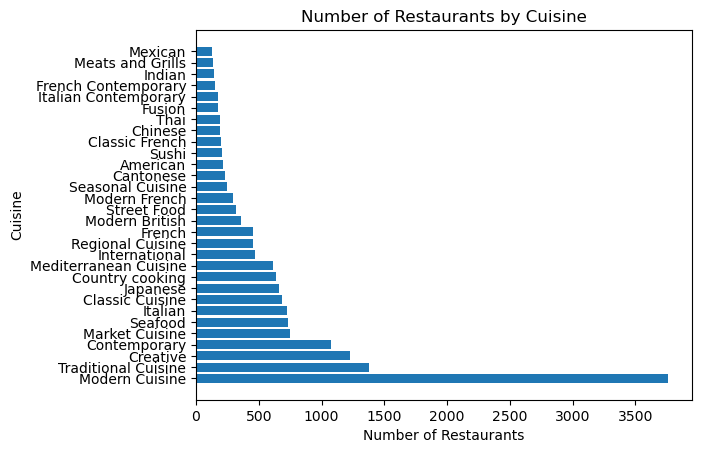

In [11]:
#df = df.sort_values(by='Number of Restaurants', ascending=False)
plt.barh(dfs['Element'], dfs['Count'])
plt.xlabel('Number of Restaurants')
plt.ylabel('Cuisine')
plt.title('Number of Restaurants by Cuisine')
plt.show()

In [12]:
country_tags= [ #'Modern Cuisine',
#  'Traditional Cuisine',
#  'Creative',
#  'Contemporary',
#  'Market Cuisine',
#  'Seafood',
 'Italian',
#  'Classic Cuisine',
 'Japanese',
#  'Country cooking',
#  'Mediterranean Cuisine',
#  'International',
#  'Regional Cuisine',
 'French',
  'Modern British',
#  'Street Food',
#  'Modern French',
#  'Seasonal Cuisine',
  'Cantonese',
#  'American',
  'Sushi',
#  'Classic French',
 'Chinese',
 'Thai',
#  'Fusion',
#  'Italian Contemporary',
#  'French Contemporary',
 'Indian',
#  'Meats and Grills',
# 'Mexican'
]

In [13]:
# filter restaurant ID that corresponds to the tag above 
# Filter the keys in the dictionary whose items are in the list
filtered_dict = {k: v for k, v in cuisine_dic.items() if any(elem in v for elem in country_tags)}

# Convert the filtered dictionary to a DataFrame
filtered_restaurant=pd.DataFrame.from_dict(filtered_dict, orient='index')#, columns=['Cuisine'])
filtered_restaurant.columns=['tag1','tag2']
filtered_restaurant['tag1'] = filtered_restaurant['tag1'].replace('Cantonese', 'Chinese')

filtered_restaurant['tag1'] = filtered_restaurant['tag1'].replace('Sushi', 'Japanese')
filtered_restaurant['tag1'] = filtered_restaurant['tag1'].replace('Modern French', 'French')

# in someg cases, a restaurant has two tags, two similar country cuisines

In [14]:
filtered_restaurant_single_tag=filtered_restaurant[filtered_restaurant['tag2'].isna()].reset_index()
filtered_restaurant_single_tag.head()

,index,tag1,tag2
0,113876,Japanese,None
1,504797,Italian,None
2,1201928,Italian,None
3,566485,French,None
4,457944,Italian,None


In [15]:
# classes are somewhat imbalanced
filtered_restaurant_single_tag.groupby('tag1').count()

#could just choose the classes that are more balanced: French, Italian, Japense, Modern British


,index,tag2
tag1,,
Chinese,311,0
French,311,0
Indian,111,0
Italian,436,0
Japanese,551,0
Modern British,339,0
Thai,166,0


In [16]:
restaurant_id_selected =list(filtered_restaurant_single_tag['index'])

In [17]:
image_names = [res_image_dic[k] for k in restaurant_id_selected]
#image_names

filtered_restaurant_single_tag['image_id']=image_names
#filtered_restaurant_single_tag

image_id_label=filtered_restaurant_single_tag.set_index('image_id')['tag1'].to_dict()
image_id_label

{'1955140': 'Japanese',
 '1956974': 'Italian',
 '4609070': 'Italian',
 '1911250': 'French',
 '4152648': 'Italian',
 '4668524': 'Italian',
 '2146157': 'Italian',
 '5611627': 'Italian',
 '2221633': 'Italian',
 '5489548': 'French',
 '2254872': 'Italian',
 '2298149': 'Italian',
 '4961770': 'Italian',
 '2051604': 'Italian',
 '2251131': 'Italian',
 '2191687': 'Italian',
 '4493783': 'Italian',
 '1908528': 'Italian',
 '2040600': 'Thai',
 '2260291': 'Chinese',
 '1958831': 'Italian',
 '2090936': 'Italian',
 '1955743': 'Italian',
 '5030848': 'Italian',
 '5471558': 'Thai',
 '1955875': 'Italian',
 '5320439': 'Italian',
 '4829194': 'Italian',
 '2694413': 'Italian',
 '2218429': 'Italian',
 '4971864': 'Chinese',
 '2156007': 'Chinese',
 '2280804': 'Japanese',
 '2142853': 'Thai',
 '4575262': 'Italian',
 '2247280': 'French',
 '2141684': 'Chinese',
 '2181089': 'Italian',
 '2117355': 'Italian',
 '4210301': 'Italian',
 '2281150': 'Italian',
 '1955330': 'Japanese',
 '5439551': 'French',
 '4670402': 'Italian'

In [18]:
# test reading an image
#folder_path = '/Users/wentingjiang/Downloads/assignment2/images'
#image_path=folder_path + '/' + image_names[0] + '.jpg'
#img=Image.open(image_path)
#img

In [19]:
# reading all images in a restaurant setting  (for relevant cuisines)
all_images={}
folder_path = '/Users/wentingjiang/Downloads/assignment2/images'
target_size = (128, 128) # use smaller size to make computation more efficient

for name in image_names:
    file_name=name + '.jpg'
    image_path = folder_path + '/' + file_name
    try:
        with Image.open(image_path) as img:
            img = img.resize(target_size)
            image_array = np.array(img)
            if image_array.shape == (128, 128, 3):
                all_images[name]=image_array
            #print(name)
    except:
        print(f"Error opening file '{file_name}', skipping...")
        continue

In [20]:
#plt.imshow(all_images['1955140'], cmap='gray')
#plt.show() # quality of 64x64 becomes much worse

In [21]:
test_image_list=[]
test_image_names=[]
test_labels=[]
for i in all_images: 
    test_image_list.append(all_images[i])
    test_image_names.append(i)
    test_labels.append(image_id_label[i])

In [22]:
test=np.array(test_image_list)
test.shape

(2202, 128, 128, 3)

In [23]:
import keras

# Filter out non-food images

In [24]:
loc='/Users/wentingjiang/Downloads/assignment2/'
# path to the folder containing the JSON files
folder_path = loc+'labels/'
# get a list of all the files in the folder
file_list = os.listdir(folder_path)

label_dict={}
# iterate over the files
for file_name in file_list:
    # check if the file is a JSON file
    if file_name.endswith('.json'):
        # construct the full path to the file
        file_path = os.path.join(folder_path, file_name)
        # open the file and read its contents
        with open(file_path, 'r') as file:
            json_data = json.load(file)        
        txt=json_data['imagePath']
        image_id=txt.split(".")[0]
        label_dict[image_id]=int(json_data['flags']['food'])
        print(json_data)

{'version': '5.1.1', 'flags': {'food': True, 'restaurant': False, 'logo': False, 'chef': False, 'food_preparation': False, 'other': False}, 'shapes': [], 'imagePath': '234812.jpg', 'imageData': None, 'imageHeight': 1000, 'imageWidth': 1000}
{'version': '5.1.1', 'flags': {'food': False, 'restaurant': True, 'logo': False, 'chef': False, 'food_preparation': False, 'other': False}, 'shapes': [], 'imagePath': '241912.jpg', 'imageData': None, 'imageHeight': 1000, 'imageWidth': 1000}
{'version': '5.1.1', 'flags': {'food': False, 'restaurant': True, 'logo': False, 'chef': False, 'food_preparation': False, 'other': False}, 'shapes': [], 'imagePath': '241857.jpg', 'imageData': None, 'imageHeight': 1000, 'imageWidth': 750}
{'version': '5.1.1', 'flags': {'food': True, 'restaurant': False, 'logo': False, 'chef': False, 'food_preparation': False, 'other': False}, 'shapes': [], 'imagePath': '213777.jpg', 'imageData': None, 'imageHeight': 1000, 'imageWidth': 1000}
{'version': '5.1.1', 'flags': {'food'

{'version': '5.1.1', 'flags': {'food': True, 'restaurant': False, 'logo': False, 'chef': False, 'food_preparation': False, 'other': False}, 'shapes': [], 'imagePath': '213989.jpg', 'imageData': None, 'imageHeight': 1000, 'imageWidth': 1000}
{'version': '5.1.1', 'flags': {'food': True, 'restaurant': False, 'logo': False, 'chef': False, 'food_preparation': False, 'other': False}, 'shapes': [], 'imagePath': '234603.jpg', 'imageData': None, 'imageHeight': 1000, 'imageWidth': 1000}
{'version': '5.1.1', 'flags': {'food': True, 'restaurant': False, 'logo': False, 'chef': False, 'food_preparation': False, 'other': False}, 'shapes': [], 'imagePath': '216322.jpg', 'imageData': None, 'imageHeight': 1000, 'imageWidth': 1000}
{'version': '5.1.1', 'flags': {'food': True, 'restaurant': False, 'logo': False, 'chef': False, 'food_preparation': False, 'other': False}, 'shapes': [], 'imagePath': '232387.jpg', 'imageData': None, 'imageHeight': 1000, 'imageWidth': 1000}
{'version': '5.1.1', 'flags': {'food

{'version': '5.1.1', 'flags': {'food': True, 'restaurant': False, 'logo': False, 'chef': False, 'food_preparation': False, 'other': False}, 'shapes': [], 'imagePath': '213471.jpg', 'imageData': None, 'imageHeight': 1000, 'imageWidth': 1000}
{'version': '5.1.1', 'flags': {'food': True, 'restaurant': False, 'logo': False, 'chef': False, 'food_preparation': False, 'other': False}, 'shapes': [], 'imagePath': '233497.jpg', 'imageData': None, 'imageHeight': 1000, 'imageWidth': 1000}
{'version': '5.1.1', 'flags': {'food': True, 'restaurant': False, 'logo': False, 'chef': False, 'food_preparation': False, 'other': False}, 'shapes': [], 'imagePath': '234217.jpg', 'imageData': None, 'imageHeight': 1000, 'imageWidth': 1000}
{'version': '5.1.1', 'flags': {'food': True, 'restaurant': False, 'logo': False, 'chef': False, 'food_preparation': False, 'other': False}, 'shapes': [], 'imagePath': '242868.jpg', 'imageData': None, 'imageHeight': 667, 'imageWidth': 1000}
{'version': '5.1.1', 'flags': {'food'

In [25]:
# just use the previous model to predict and see the outcome

image_names_test=list(label_dict.keys())
image_labels_test=list(label_dict.values())

# reading all images in a restaurant setting 
#all_test_images={}
folder_path = loc+'images'
target_size = (128, 128) # need to resize because some images do not have the same shap

# read all
test_label=[]
new_test_image_list= []
for ind,name in enumerate(image_names_test):
    file_name=name + '.jpg'
    image_path = folder_path + '/' + file_name
    try:
        with Image.open(image_path) as img:
            img = img.resize(target_size)
            image_array = np.array(img)
            #all_test_images[name]=image_array       
            new_test_image_list.append(image_array)
            test_label.append(image_labels_test[ind])
            #print(name)
    except:
        print(f"Error opening file '{file_name}', skipping...")
        continue

print('read ' + str(len(new_test_image_list)) + ' images')

sum(test_label)/len(test_label)
# there is a slight issue of class imbalance, accuracy is not be the best metric

read 1184 images


0.6613175675675675

In [26]:
new_test=np.array(new_test_image_list)
new_test.shape

(1184, 128, 128, 3)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    new_test, np.array(test_label), test_size=0.2, stratify=np.array(test_label), random_state=42)

In [28]:
from sklearn.utils.class_weight import compute_class_weight

In [29]:
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                    
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 1.4750778816199377, 1: 0.7563897763578274}

In [46]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications import VGG16
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Load the pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze pre-trained layers (compare with no freezing)
for layer in base_model.layers:
    layer.trainable = False
    
early_stopping = EarlyStopping(monitor='val_loss', patience=2)


# Define your own classification layers
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


learning_rate = 0.001 # or any other value you want to try
adam = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1048704   
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 15,763,521
Trainable params: 1,048,833
Non-trainable params: 14,714,688
_________________________________________________________________


In [47]:
# Train the model
history=model.fit(X_train, y_train, class_weight=class_weights, 
                  epochs=5, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# Evaluate the model on test set
#score = model.evaluate(X_test, y_test)
#print('Test accuracy:', score[1])

Epoch 1/5
30/30 [==============================] - 57s 2s/step - loss: 3.5662 - accuracy: 0.9155 - val_loss: 0.6041 - val_accuracy: 0.9747
Epoch 2/5
30/30 [==============================] - 71s 2s/step - loss: 0.0935 - accuracy: 0.9884 - val_loss: 0.3170 - val_accuracy: 0.9831
Epoch 3/5
30/30 [==============================] - 67s 2s/step - loss: 0.0145 - accuracy: 0.9947 - val_loss: 0.3329 - val_accuracy: 0.9789
Epoch 4/5
30/30 [==============================] - 74s 3s/step - loss: 0.0046 - accuracy: 0.9989 - val_loss: 0.3403 - val_accuracy: 0.9831


In [51]:
model.save("my_model.h5")

In [52]:
# Load the model
model = load_model("my_model.h5")

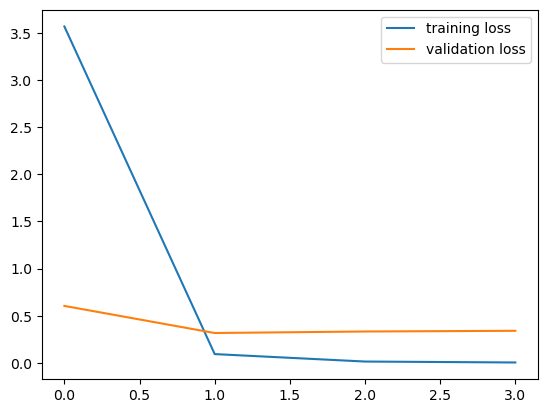

In [53]:
# plot loss curve
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [30]:
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, RMSprop

# Define a list of hyperparameters to try
learning_rates = [0.001, 0.0001]
optimizers = [Adam, SGD, Adagrad, RMSprop]
batch_sizes = [32]
dropout_rates = [0.1]
num_hidden_layers = [1]
activation_functions = ['sigmoid']

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['learning_rate', 'optimizer', 'batch_size', 'dropout_rate', 'num_hidden_layers', 'activation_function', 'val_accuracy', 'history'])

# Loop over all combinations of hyperparameters
for lr in learning_rates:
    for opt in optimizers:
        for bs in batch_sizes:
            for dr in dropout_rates:
                for nl in num_hidden_layers:
                    for act in activation_functions:
                        # Load the pre-trained model
                        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

                        # Freeze pre-trained layers (compare with no freezing)
                        for layer in base_model.layers:
                            layer.trainable = False

                        early_stopping = EarlyStopping(monitor='val_loss', patience=2)

                        # Define your own classification layers
                        model = Sequential()
                        model.add(base_model)
                        model.add(Flatten())
                        for i in range(nl):
                            model.add(Dense(128, activation=act))
                            model.add(Dropout(dr))
                        model.add(Dense(1, activation='sigmoid'))

                        # Compile the model
                        optimizer = opt(learning_rate=lr)
                        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

                        # Train the model and save the validation accuracy and history
                        history = model.fit(X_train, y_train, class_weight=class_weights, epochs=10, batch_size=bs, validation_data=(X_test, y_test), callbacks=[early_stopping])
                        val_accuracy = history.history['val_accuracy'][-1]

                        # Append the results to the DataFrame
                        my_dict ={'learning_rate': lr, 'optimizer': opt.__name__, 'batch_size': 
 bs, 'dropout_rate': dr, 'num_hidden_layers': nl, 'activation_function': act, 'val_accuracy': val_accuracy, 'history': history}           

                        temp = pd.DataFrame.from_dict(my_dict, orient='index').T
                        results_df = pd.concat([results_df, temp], ignore_index=True)
                        
# Print the results
print(results_df)

2023-05-06 09:54:26.072293: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
30/30 [==============================] - 72s 2s/step - loss: 0.1797 - accuracy: 0.9514 - val_loss: 0.0655 - val_accuracy: 0.9831
Epoch 2/10
30/30 [==============================] - 87s 3s/step - loss: 0.0998 - accuracy: 0.9725 - val_loss: 0.0653 - val_accuracy: 0.9831
Epoch 3/10
30/30 [==============================] - 77s 3s/step - loss: 0.0845 - accuracy: 0.9778 - val_loss: 0.0678 - val_accuracy: 0.9789
Epoch 4/10
30/30 [==============================] - 79s 3s/step - loss: 0.0734 - accuracy: 0.9820 - val_loss: 0.0709 - val_accuracy: 0.9831
Epoch 1/10
30/30 [==============================] - 77s 3s/step - loss: 0.5618 - accuracy: 0.7254 - val_loss: 0.3863 - val_accuracy: 0.8987
Epoch 2/10
30/30 [==============================] - 74s 2s/step - loss: 0.3533 - accuracy: 0.9029 - val_loss: 0.2795 - val_accuracy: 0.9451
Epoch 3/10
30/30 [==============================] - 75s 3s/step - loss: 0.2633 - accuracy: 0.9493 - val_loss: 0.2300 - val_accuracy: 0.9705
Epoch 4/10
30/30 [==

30/30 [==============================] - 75s 3s/step - loss: 0.0920 - accuracy: 0.9831 - val_loss: 0.0751 - val_accuracy: 0.9831
Epoch 3/10
30/30 [==============================] - 74s 2s/step - loss: 0.0619 - accuracy: 0.9873 - val_loss: 0.0679 - val_accuracy: 0.9831
Epoch 4/10
30/30 [==============================] - 77s 3s/step - loss: 0.0481 - accuracy: 0.9884 - val_loss: 0.0633 - val_accuracy: 0.9831
Epoch 5/10
30/30 [==============================] - 74s 2s/step - loss: 0.0366 - accuracy: 0.9916 - val_loss: 0.0635 - val_accuracy: 0.9831
Epoch 6/10
30/30 [==============================] - 77s 3s/step - loss: 0.0337 - accuracy: 0.9916 - val_loss: 0.0638 - val_accuracy: 0.9831
  learning_rate optimizer batch_size dropout_rate num_hidden_layers   
0         0.001      Adam         32          0.1                 1  \
1         0.001       SGD         32          0.1                 1   
2         0.001   Adagrad         32          0.1                 1   
3         0.001   RMSprop  

In [31]:
#results_df.to_csv('model_compare2.csv')

In [38]:
#results_df[['learning_rate', 'optimizer', 'val_accuracy']]

results_df3 = results_df[['learning_rate', 'optimizer', 'val_accuracy', 'history']]
results_df3

,learning_rate,optimizer,val_accuracy,history
0,0.001,Adam,0.983122,<keras.callbacks.History object at 0x7f8521380...
1,0.001,SGD,0.983122,<keras.callbacks.History object at 0x7f8425afc...
2,0.001,Adagrad,0.983122,<keras.callbacks.History object at 0x7f8425d15...
3,0.001,RMSprop,0.987342,<keras.callbacks.History object at 0x7f8427024...
4,0.0001,Adam,0.983122,<keras.callbacks.History object at 0x7f8428051...
5,0.0001,SGD,0.852321,<keras.callbacks.History object at 0x7f84295cb...
6,0.0001,Adagrad,0.932489,<keras.callbacks.History object at 0x7f842b68a...
7,0.0001,RMSprop,0.983122,<keras.callbacks.History object at 0x7f843418d...


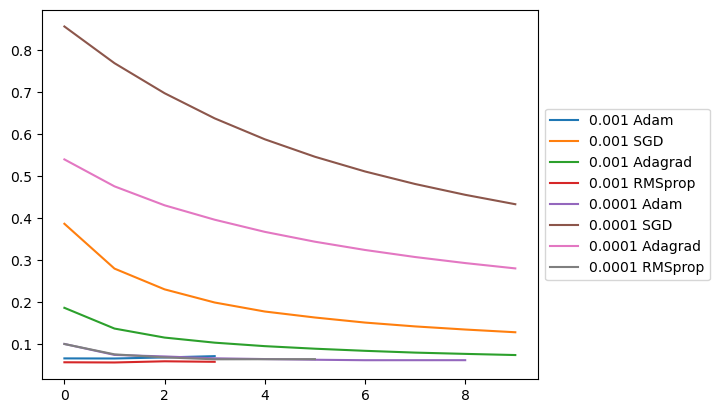

In [40]:
fig, ax = plt.subplots()

for index, row in results_df3.iterrows():
    ax.plot(row['history'].history['val_loss'], label=f"{row['learning_rate']} {row['optimizer']}")

# create a legend object
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [ ]:
#results_df.to_csv('model_compare.csv')

In [54]:
model_predictions_test=model.predict(X_test)
threshold = 0.99999 # play around this threshold

predicted_labels_test = (model_predictions_test > threshold).astype(int)

accuracy = accuracy_score(y_test, predicted_labels_test)
print(accuracy) 

8/8 [==============================] - 12s 2s/step
0.9113924050632911


In [55]:
sum(predicted_labels_test)

array([142])

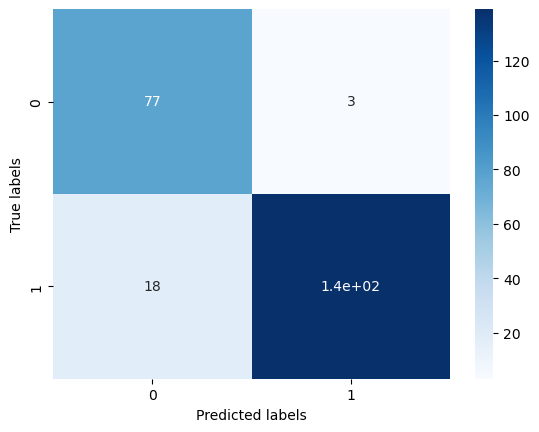

In [56]:
# Compute confusion matrix
cm = confusion_matrix(y_test, predicted_labels_test)

# Plot heatmap
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
convert_label_dict={1: 'food', 0: 'exterior'}

In [ ]:
#find misclassified images
def find_mismatch_pos(list1, list2):
    all_pos=[]
    for i in range(len(list1)):
        if list1[i] != list2[i]:
            all_pos.append(i)
    return all_pos # if no mismatch found

misclassified = find_mismatch_pos(y_test, predicted_labels_test)

In [ ]:
for ind, item in enumerate(misclassified):
    predict_label=predicted_labels_test[item][0]
    actual_label=y_test[item]
    print('image ' + str(ind) + ' actual label:' + (convert_label_dict[actual_label]))
    print('image ' + str(ind) + ' predict label:' + (convert_label_dict[predict_label]))
    plt.imshow(new_test[item], cmap='gray')
    plt.show()
    
# image 4 has a wrong label

In [ ]:
 # show images in order to check prediction 
for ind, item in enumerate(X_test):
    label=predicted_labels_test[ind][0]
    print('image ' + str(ind) + ' label:' + (convert_label_dict[label]))
    plt.imshow(item, cmap='gray')
    plt.show()

In [ ]:
def save_image(filename):
    p = PdfPages(filename)
    for ind, item in enumerate(new_images): # show images in order to check prediction 
        label=predicted_labels[ind][0]
        fig= plt.figure()
        plt.imshow(item, cmap='gray')
        plt.title('image ' + str(ind) + ' label:' + (convert_label_dict[label]))
        fig.savefig(p, format='pdf') 
    # close the object
    p.close()  
    
# name Pdf file
#filename = "multi_plot_image2.pdf"  
#save_image(filename)  

# Load saved food vs exterior model

In [ ]:
import os
os.getcwd()

In [ ]:
from keras.models import load_model

In [ ]:
import tensorflow as tf

In [ ]:
#new_model = tf.keras.models.load_model('food_interior_classifier.h5')

In [ ]:
# Predict new images with the model
model_predictions=model.predict(test)

In [ ]:
plt.hist(model_predictions) # probabilities are at two extreme

In [ ]:
# set the threshold
threshold = 0.5 # adjust this threshold to make sure what we predict as food is really food

# convert predicted probabilities to labels 0 and 1
predicted_labels = (model_predictions > threshold).astype(int)
# print the predicted labels

In [ ]:
test.shape

In [ ]:
sum(predicted_labels)

In [ ]:
label_dict={1: 'food', 0: 'exterior'}
predicted=[]

food_only=[]
cuisine_labels=[]
image_name=[]
for ind, item in enumerate(test): # show images in order to check prediction 
    label=predicted_labels[ind][0]
    predicted.append(label)
    if label==1:
        food_only.append(item)
        cuisine_labels.append(test_labels[ind])
        image_name.append(test_image_names[ind])
    #print('image ' + str(ind) + ' label:' + (label_dict[label]))
    #plt.imshow(item, cmap='gray')
    #plt.show()

In [ ]:
len(test)

In [ ]:
with open('food_only.txt', 'w') as f:
    for item in image_name:
        f.write("%s\n" % item)

In [ ]:
len(food_only)

In [ ]:
# double check labels
#for test_id in range(10):
#    plt.imshow(food_only[test_id], cmap='gray')
#    plt.title(cuisine_labels[test_id])
#    plt.show()

round(sum(predicted)/len(predicted),2)
# percent predicted as food images

In [ ]:
def save_image(filename, food_only):
    p = PdfPages(filename)
    for ind, item in enumerate(food_only): # show images in order to check prediction 
        #label=predicted_labels[ind][0]
        fig= plt.figure()
        plt.imshow(item, cmap='gray')
        plt.title('image ' + str(image_name[ind]))
        fig.savefig(p, format='pdf') 
    # close the object
    p.close()
#filename = "cuisine_food_predicted2.pdf"  
#save_image(filename, food_only) 

In [ ]:
#test_image_names, this contains the labels of the test image

# Check about the interior

In [ ]:
#wrong =['2643058', '778212', '297614', '5414007', '5142831', '2026022', '1250600', '1004760', '2241860', '1198837', '1943514']

In [ ]:
# indices = [i for i, x in enumerate(image_name) if x in wrong]
# indices

In [ ]:
# cuisine_labels_filtered = [cuisine_labels[i] for i in range(len(cuisine_labels)) if i not in indices]

In [ ]:
# food_only_filtered = [food_only[i] for i in range(len(food_only)) if i not in indices]

# Modelling after filtering out non-food

In [ ]:
import keras

In [ ]:
final_labels= cuisine_labels.copy()

In [ ]:
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'species'.
final_labels_int= label_encoder.fit_transform(final_labels)

In [ ]:
class_cat=pd.DataFrame(final_labels)
class_cat.columns=['label']
dummies = pd.get_dummies(class_cat)
dummies.shape

In [ ]:
set(final_labels)

In [ ]:
class_cat.reset_index().groupby('label').count()

In [ ]:
X = np.array(food_only)
y= np.array(dummies)

In [ ]:
import functools
#https://stackoverflow.com/questions/51951358/keras-how-to-get-top-k-accuracy
#top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)
#top3_acc.__name__ = 'top3_acc'

#original_labels = np.argmax(y, axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify= final_labels_int, test_size=0.2, random_state=42)

In [ ]:
# class_weights2 = compute_class_weight(
#                                         class_weight = "balanced",
#                                         classes = np.unique(final_labels_int),
#                                         y = final_labels_int                                                    
#                                     )
# class_weights2 = dict(zip(np.unique(final_labels_int), class_weights))
# class_weights2

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications import VGG16

from tensorflow.keras.layers import Dropout


# Load the pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze pre-trained layers (compare with no freezing)
for layer in base_model.layers:
    layer.trainable = False

early_stopping = EarlyStopping(monitor='val_loss', patience=4)

    
# Define your own classification layers
model_cusine = Sequential()
model_cusine.add(base_model)
model_cusine.add(Dropout(0.2)) # avoid overfitting
model_cusine.add(Flatten())


#model.add(Dense(128, activation='relu'))

#val acc>0.2
model_cusine.add(Dense(64, activation='relu'))
#model.add(Dropout(0.2)) # adding it twuice to avoid overfitting
model_cusine.add(Dense(64, activation='relu'))
#model.add(Dropout(0.2)) # adding it twuice to avoid overfitting

model_cusine.add(Dense(7, activation='softmax'))
#https://datascience.stackexchange.com/questions/39264/how-does-sigmoid-activation-work-in-multi-class-classification-problems

# Compile the model
model_cusine.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy','top_k_categorical_accuracy'])
              #,top3_acc]) #sparse_categorical_crossentropy

In [ ]:
model_cusine.summary()

In [ ]:
original_labels_y_train = np.argmax(y_train, axis=1)


# from sklearn.utils import class_weight
# class_weights = compute_class_weight(class_weight = "balanced",
#                                          classes = np.unique(original_labels_y_train),
#                                          y = original_labels_y_train                                                    
#                                      )
# class_weights = dict(zip(np.unique(original_labels_y_train), class_weights))

In [ ]:
class_weights

In [ ]:
# Train the model
history2=model_cusine.fit(X_train, y_train, #class_weight=class_weights, 
                          epochs=10, batch_size=16, 
                          validation_data=(X_test, y_test), callbacks=[early_stopping])


# Evaluate the model on test set
#score = model_cusine.evaluate(X_test, y_test)
#print('Test accuracy:', score[1])

In [ ]:
# plot loss curve
plt.plot(history2.history['loss'], label='training loss')
plt.plot(history2.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [ ]:
y_pred_prob = model_cusine.predict(X)
y_pred = [int(np.argmax(i) )for i in y_pred_prob]

In [ ]:
#y_pred_prob = model_cusine.predict(X_test)
#y_pred = [int(np.argmax(i) )for i in y_pred_prob]

In [ ]:
original_labels = np.argmax(y, axis=1)
original_labels

In [ ]:
y[1]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Define your actual class names as a list
class_names = ['Chinese',
 'French',
 'Indian',
 'Italian',
 'Japanese',
 'Modern British',
 'Thai']

# Generate some example data for demonstration purposes
# Including both training and test
y_pred = y_pred
y_true = original_labels

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

In [ ]:
# Define a function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Plot the confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')
plt.show()


In [ ]:
# to do

In [ ]:
# Manually go through the food images, anyone exterior image there? 

In [ ]:
# Now either consider class weight, or make them more balanced manually

In [ ]:
# Try different losses, sparse_categorical vs categorical, try using y as label encoded vs dummy encoded

In [ ]:
# Look at some misclassified images

In [ ]:
# Add explanation technique